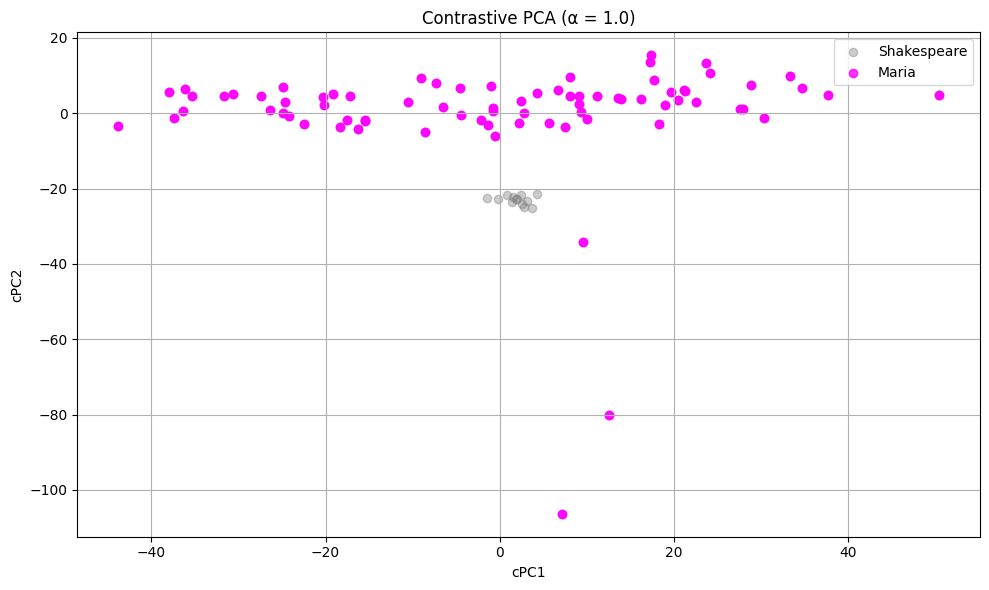

Contrastive PCA complete! Projection + plot saved.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh

# Load GPT-2 activation matrices
X_target = np.load("maria_gpt2.npy")       # Maria's poetry
X_background = np.load("shakespeare_gpt2.npy")  # Shakespeare

# Optional: standardize features
scaler = StandardScaler()
X_target = scaler.fit_transform(X_target)
X_background = scaler.transform(X_background)

# Compute covariance matrices
C_target = np.cov(X_target, rowvar=False)
C_background = np.cov(X_background, rowvar=False)

# Contrastive covariance matrix
alpha = 1.0  # You can try values like 0.1, 0.5, 1, 2
C_contrastive = C_target - alpha * C_background

# Eigen-decomposition of contrastive matrix
eigvals, eigvecs = eigh(C_contrastive)
idx = np.argsort(eigvals)[::-1]
eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

# Project target and background onto top 2 contrastive components
W = eigvecs[:, :2]
X_target_proj = X_target @ W
X_background_proj = X_background @ W

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_background_proj[:, 0], X_background_proj[:, 1], alpha=0.4, label="Shakespeare", color='gray')
plt.scatter(X_target_proj[:, 0], X_target_proj[:, 1], alpha=0.8, label="Maria", color='magenta')
plt.legend()
plt.title("Contrastive PCA (α = {})".format(alpha))
plt.xlabel("cPC1")
plt.ylabel("cPC2")
plt.grid(True)
plt.tight_layout()
plt.savefig("cpca_plot.png")
plt.show()

# Save projected points
np.save("cpca_maria_proj.npy", X_target_proj)
np.save("cpca_shakespeare_proj.npy", X_background_proj)
np.save("cpca_components.npy", W)

print("Contrastive PCA complete! Projection + plot saved.")


In [4]:
X_maria = np.load("maria_gpt2.npy")
X_shakespeare = np.load("shakespeare_gpt2.npy")

# Assuming layers are [layer3 | layer6 | layer9 | layer12], each 768-dim
X_maria_layer6 = X_maria[:, 768:768*2]
X_shakespeare_layer6 = X_shakespeare[:, 768:768*2]

np.save("maria_layer6.npy", X_maria_layer6)
np.save("shakespeare_layer6.npy", X_shakespeare_layer6)


In [13]:
print(X_maria_layer6[0]==X_shakespeare_layer6[0])

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

(154, 768)


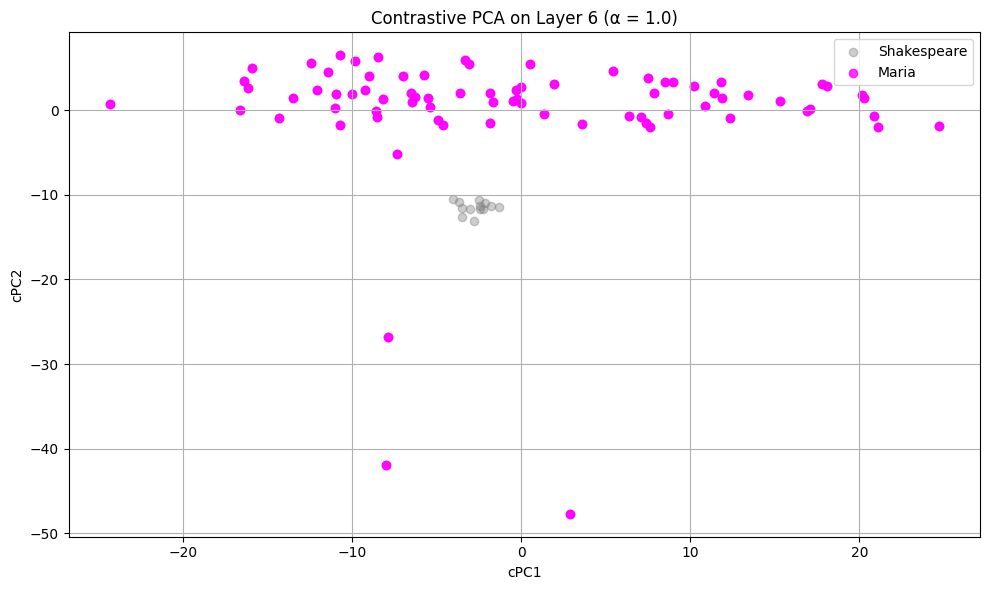

✅ Saved: cpca_layer6_cpc1.npy


In [6]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy.linalg import eigh

# Load layer6-only activations
X_target = np.load("maria_layer6.npy")
X_background = np.load("shakespeare_layer6.npy")
print(X_target.shape)
# Normalize
scaler = StandardScaler()
X_target = scaler.fit_transform(X_target)
X_background = scaler.transform(X_background)

# Compute covariance matrices
C_target = np.cov(X_target, rowvar=False)
C_background = np.cov(X_background, rowvar=False)

# Contrastive PCA
alpha = 1.0
C_contrastive = C_target - alpha * C_background
eigvals, eigvecs = eigh(C_contrastive)
idx = np.argsort(eigvals)[::-1]
eigvals, eigvecs = eigvals[idx], eigvecs[:, idx]

# Project data
W = eigvecs[:, :2]
X_target_proj = X_target @ W
X_background_proj = X_background @ W

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_background_proj[:, 0], X_background_proj[:, 1], alpha=0.4, label="Shakespeare", color='gray')
plt.scatter(X_target_proj[:, 0], X_target_proj[:, 1], alpha=0.8, label="Maria", color='magenta')
plt.title("Contrastive PCA on Layer 6 (α = 1.0)")
plt.xlabel("cPC1")
plt.ylabel("cPC2")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("cpca_layer6.png")
plt.show()

# Save the primary component for injection
np.save("cpca_layer6_cpc1.npy", eigvecs[:, 0])

print("✅ Saved: cpca_layer6_cpc1.npy")


In [8]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np

# Load cPCA vector (assumes it's [3072] — same shape as pooled GPT-2 vector)
cpca_vector = np.load("cpca_layer6_cpc1.npy")  # cPC1
cpca_vector = torch.tensor(cpca_vector, dtype=torch.float32)

# Load GPT-2 and tokenizer
model_name = "openai-community/gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, output_hidden_states=True)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

cpca_vector = cpca_vector.to(device)

# Prompt
prompt = "The nature of intelligence lies in"

inputs = tokenizer(prompt, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states  # tuple of (13, batch, seq_len, hidden_size)
    residual = hidden_states[12][0]  # final layer, shape [seq_len, hidden_size]

# Inject the vector at the final token position
injected_residual = residual.clone()
lambda_scale = 5.0  # Strength of injection — tune this!
injected_residual[-1] += lambda_scale * cpca_vector

# Replace original hidden state
def custom_forward(*args, **kwargs):
    kwargs['output_hidden_states'] = True
    return model.base_model(*args, **kwargs)

# Manually construct output with new final hidden state
with torch.no_grad():
    lm_head = model.lm_head
    logits = lm_head(injected_residual.unsqueeze(0))  # [1, seq_len, vocab]
    next_token_id = torch.argmax(logits[0, -1]).item()
    next_token = tokenizer.decode(next_token_id)

print(f"\nPrompt: {prompt}")
print(f"Next token (steered): {next_token}")


/home/maria/Neurogarage2/.venv/lib/python3.12/site-packages/transformers/generation/configuration_utils.py:818: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_hidden_states` is. When `return_dict_in_generate` is not `True`, `output_hidden_states` is ignored.
  warnings.warn(



Prompt: The nature of intelligence lies in
Next token (steered):  the


In [9]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np

# Load the cPC1 direction from layer 6
cpca_vector = np.load("cpca_layer6_cpc1.npy")  # shape [768]
cpca_vector = torch.tensor(cpca_vector, dtype=torch.float32)

# Load GPT-2
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name, output_hidden_states=True)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
cpca_vector = cpca_vector.to(device)

# Prompt
prompt = "The nature of intelligence lies in"
inputs = tokenizer(prompt, return_tensors="pt").to(device)

# Forward pass to layer 6
with torch.no_grad():
    outputs = model.transformer(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states  # tuple of (13, batch, seq_len, hidden_size)
    residual = hidden_states[6][0]  # layer 6 output, [seq_len, hidden_dim]

# Inject poetic direction into final token position
lambda_scale = 5.0  # try 1.0 to 10.0
injected_residual = residual.clone()
injected_residual[-1] += lambda_scale * cpca_vector

# Continue generation from the modified hidden state
# We'll only use this final vector to predict next token
with torch.no_grad():
    logits = model.lm_head(injected_residual.unsqueeze(0))  # [1, seq_len, vocab]
    next_token_id = torch.argmax(logits[0, -1]).item()
    next_token = tokenizer.decode(next_token_id)

print(f"\nPrompt: {prompt}")
print(f"Next token (with Maria-cPC1 injected): {next_token}")



Prompt: The nature of intelligence lies in
Next token (with Maria-cPC1 injected):  the


In [10]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np

# Load the poetic direction
cpca_vector = np.load("cpca_layer6_cpc1.npy")  # shape [768]
cpca_vector = torch.tensor(cpca_vector, dtype=torch.float32)

# Load GPT-2
model_name = "gpt2"
tokenizer = GPT2Tokenizer.from_pretrained(model_name)
model = GPT2LMHeadModel.from_pretrained(model_name)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
cpca_vector = cpca_vector.to(device)

# Prompt
prompt = "The nature of intelligence lies in"
inputs = tokenizer(prompt, return_tensors="pt").to(device)
input_ids = inputs["input_ids"]

# Forward pass to get internal states
with torch.no_grad():
    outputs = model.transformer(**inputs, output_hidden_states=True)
    hidden_states = outputs.hidden_states
    residual = hidden_states[6][0]  # shape [seq_len, 768]

# Inject the poetic vector at the last token
lambda_scale = 5.0
residual[-1] += lambda_scale * cpca_vector

# Pass only the final token's injected hidden state through the head
with torch.no_grad():
    logits = model.lm_head(residual.unsqueeze(0))
    next_token_id = torch.argmax(logits[0, -1]).unsqueeze(0)
    input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=1)

# Now use standard generation to continue from here
output = model.generate(
    input_ids=input_ids,
    max_new_tokens=130,  # approx 117 words
    do_sample=True,
    top_k=50,
    top_p=0.95,
    temperature=0.8,
    eos_token_id=tokenizer.eos_token_id,
)

result = tokenizer.decode(output[0], skip_special_tokens=True)
print("\n📝 Generated Poetic Output:\n")
print(result)


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.



📝 Generated Poetic Output:

The nature of intelligence lies in the way we make decisions about ourselves. For example, we know that information is not good for us, because we're not born with the ability to measure it. We're born with the ability to measure and measure. And so we're in the process of making decisions. We're making decisions because we're human beings.

And so, the way we think and what we do as a group is ultimately based on the values we hold. And that's how the people who write our books — and they know the way we think and how we think — they see us as human beings.

In the book you describe, there are many


In [ ]:
import torch
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import numpy as np

# --- Config ---
SEED = 42
LAYER = 6
LAMBDA = 5.0
MAX_TOKENS = 130  # ~117 words
TEMPERATURE = 0.8

# --- Seed for reproducibility ---
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

# --- Load vector ---
cpca_vector = np.load("cpca_layer6_cpc1.npy")
cpca_vector = torch.tensor(cpca_vector, dtype=torch.float32)

# --- Load model ---
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model = GPT2LMHeadModel.from_pretrained("gpt2")
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
cpca_vector = cpca_vector.to(device)

# --- Prompt ---
prompt = "The nature of intelligence lies in"
inputs = tokenizer(prompt, return_tensors="pt", return_attention_mask=True).to(device)
input_ids = inputs["input_ids"]
attention_mask = inputs["attention_mask"]

# --- Forward pass to get hidden states ---
with torch.no_grad():
    outputs = model.transformer(input_ids=input_ids, attention_mask=attention_mask, output_hidden_states=True)
    residual = outputs.hidden_states[LAYER][0]  # shape: [seq_len, hidden_dim]

# --- Inject poetic vector ---
injected_residual = residual.clone()
injected_residual[-1] += LAMBDA * cpca_vector

# --- Run one step with injection ---
with torch.no_grad():
    logits = model.lm_head(injected_residual.unsqueeze(0))
    next_token_id = torch.argmax(logits[0, -1]).unsqueeze(0)
    input_ids = torch.cat([input_ids, next_token_id.unsqueeze(0)], dim=1)
    attention_mask = torch.cat([attention_mask, torch.ones_like(next_token_id.unsqueeze(0))], dim=1)

# --- Continue generation ---
output = model.generate(
    input_ids=input_ids,
    attention_mask=attention_mask,
    max_new_tokens=MAX_TOKENS,
    do_sample=True,
    temperature=TEMPERATURE,
    top_k=50,
    top_p=0.95,
    pad_token_id=tokenizer.eos_token_id,
    eos_token_id=tokenizer.eos_token_id,
)

result = tokenizer.decode(output[0], skip_special_tokens=True)

print("\n📝 Generated Poetic Output:\n")
print(result)



📝 Generated Poetic Output:

The nature of intelligence lies in my ability to understand that the more I understand something, the more likely I am to understand it."

To help people understand intelligence, researchers at the University of Cambridge, UK, devised a computer program that can tell you if something is true or false. It can also tell you if the information is incorrect. They are now trying to learn how the computer works to improve the way it uses information in the world.

What's more, the researchers are using the data they've collected to make predictions about how intelligence might evolve. "It's more like, "How many more years does intelligence take?" and they're saying, "How many
